In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.applications.vgg16 import VGG16
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import time

In [ ]:
!unzip Dataset.zip

In [3]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256,256,3))

58889256/58889256 [==============================] - 1s 0us/step


In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [5]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [6]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'Dataset/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'Dataset/validation',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 120 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [7]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23136577 (88.26 MB)
Trainable params: 23136577 (88.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
conv_base.trainable = False

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23136577 (88.26 MB)
Trainable params: 8421889 (32.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
start_time = time.time()
history = model.fit(train_ds,epochs=20,validation_data=validation_ds)
end_time = time.time()
training_time = end_time - start_time
print("\n")
print("Training time = ", training_time)

Epoch 1/20
4/4 [==============================] - 21s 3s/step - loss: 2.3986 - accuracy: 0.5083 - val_loss: 1.3986 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 1s 280ms/step - loss: 0.8528 - accuracy: 0.6333 - val_loss: 0.5158 - val_accuracy: 0.7000
Epoch 3/20
4/4 [==============================] - 2s 378ms/step - loss: 0.4758 - accuracy: 0.7833 - val_loss: 0.4834 - val_accuracy: 0.7750
Epoch 4/20
4/4 [==============================] - 1s 264ms/step - loss: 0.2865 - accuracy: 0.8667 - val_loss: 0.3794 - val_accuracy: 0.7750
Epoch 5/20
4/4 [==============================] - 1s 265ms/step - loss: 0.1724 - accuracy: 0.9500 - val_loss: 0.1763 - val_accuracy: 0.9250
Epoch 6/20
4/4 [==============================] - 1s 258ms/step - loss: 0.0833 - accuracy: 0.9667 - val_loss: 0.2823 - val_accuracy: 0.8500
Epoch 7/20
4/4 [==============================] - 1s 275ms/step - loss: 0.0294 - accuracy: 0.9833 - val_loss: 0.3082 - val_accuracy: 0.8500
Epoch 8/20
4/4 [======

1/1 [==============================] - 1s 1s/step


array([[0.]], dtype=float32)

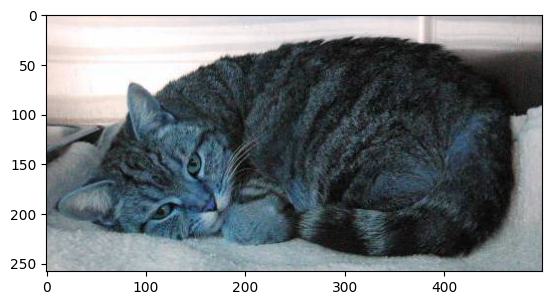

In [13]:
test_img1 = cv2.imread('/content/Dataset/test/cat/cat.76.jpg')
plt.imshow(test_img1)
test_img1 = cv2.resize(test_img1,(256,256))
test_input1 = test_img1.reshape((1,256,256,3))
model.predict(test_input1)

1/1 [==============================] - 0s 26ms/step


array([[1.]], dtype=float32)

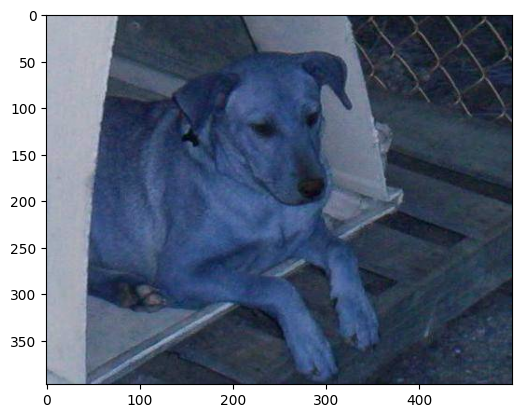

In [14]:
test_img2 = cv2.imread('/content/Dataset/test/dog/dog.100.jpg')
plt.imshow(test_img2)
test_img2 = cv2.resize(test_img2,(256,256))
test_input2 = test_img2.reshape((1,256,256,3))
model.predict(test_input2)

In [15]:
# Load test dataset
test_ds = keras.utils.image_dataset_from_directory(
    directory='Dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

# Preprocess test data
test_ds = test_ds.map(process)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_ds)
# Log testing accuracy
tf.summary.scalar('test_accuracy', test_accuracy, step=60)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 40 files belonging to 2 classes.
2/2 [==============================] - 0s 70ms/step - loss: 0.2801 - accuracy: 0.9250
Test Loss: 0.28013625741004944
Test Accuracy: 0.925000011920929


1/1 [==============================] - 0s 149ms/step


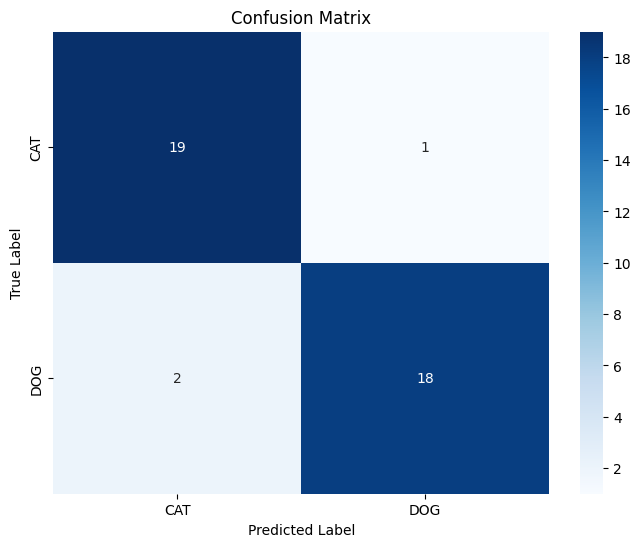

In [16]:
# Function to get predictions
def get_predictions(model, dataset):
    predictions = []
    labels = []
    for images, labels_batch in dataset:
        predictions_batch = model.predict(images)
        predictions.extend(np.round(predictions_batch).astype(int))
        labels.extend(labels_batch.numpy())
    return np.array(predictions).flatten(), np.array(labels)

# Get predictions for test data
test_predictions, test_labels = get_predictions(model, test_ds)

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CAT', 'DOG'], yticklabels=['CAT', 'DOG'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()